[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/11au9s4Hox89d0zcU1GjwuAERdEteoFxJ?usp=sharing)

Source: https://github.com/ezponda/intro_deep_learning/blob/main/class/RNN/IMBD_RNN.ipynb

# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

tf.keras.utils.set_random_seed(0)


def show_loss_accuracy_evolution(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The  parameter `num_words` controls how many words different we want to use.

In [ ]:
from tensorflow.keras.datasets import imdb
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [ ]:
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


For transforming an id-sequence to a phrase use get_words

In [ ]:
def get_words(sentence, int2word):
    return ' '.join([int2word.get(i, '<UNK>') for i in sentence])


get_words(train_data[0], int2word)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# MLP model

## Data Preprocessing

You need to convert your raw text to an appropriate input to a sequential model

In [ ]:
def vectorize_text_sentence(text, word2int):
    tokens = text.split(' ')
    tokens_id = [word2int.get(tk,2) for tk in tokens]
    return tokens_id

text = get_words(train_data[0], int2word)
print(text)
print(vectorize_text_sentence(text, word2int))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

We are going to use a bag of words model. BoW is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the Each key is the word, and each value is the frequency of occurrences of that word in the given text document.

- **Input document**: `"John likes to watch movies Mary likes movies too"`
- **BoW**: `{'John': 0.11, 'likes': 0.22, 'to': 0.11, 'watch': 0.11, 'movies': 0.22, 'Mary': 0.11, 'too': 0.11}`


In [ ]:
from collections import Counter


def get_bag_of_words(sequence, norm=True):
    word_count = Counter(sequence)
    if norm:
        total = sum(word_count.values())
        word_freq = {w: n / total for w, n in word_count.items()}
        return word_freq
    else:
        return dict(word_count.items())


text_example = "John likes to watch movies Mary likes movies too"
print('text_example', text_example)
text_sequence = text_example.split()
print('text splitted', text_sequence)
bag_of_words = get_bag_of_words(text_sequence)
print('bag_of_words', bag_of_words)
print('bag_of_words norm=False', get_bag_of_words(text_sequence, norm=False))
print(
    'bag_of_words with indexes', {
        word2int[w.lower()]: p
        for w, p in get_bag_of_words(text_sequence, norm=False).items()
    })

text_example John likes to watch movies Mary likes movies too
text splitted ['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too']
bag_of_words {'John': 0.1111111111111111, 'likes': 0.2222222222222222, 'to': 0.1111111111111111, 'watch': 0.1111111111111111, 'movies': 0.2222222222222222, 'Mary': 0.1111111111111111, 'too': 0.1111111111111111}
bag_of_words norm=False {'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}
bag_of_words with indexes {308: 1, 1232: 2, 8: 1, 106: 1, 102: 2, 1083: 1, 99: 1}


After that, we convert every BoW to a vector of `dim=num_words` with `vectorize_sequences`

In [ ]:
def vectorize_sequence(sequence, num_words, norm=True):
    vec = np.zeros(num_words)
    bow = get_bag_of_words(sequence, norm)
    for w, freq in bow.items():
        if w < num_words:
            vec[w] = freq
    return vec


def vectorize_sequences(sequences, num_words=num_words, norm=True):
    """Creates an all-zero matrix of shape (len(sequences), num_words)"""
    results = np.zeros((len(sequences), num_words))
    for i, sequence in enumerate(sequences):
        results[i, :] = vectorize_sequence(sequence, num_words, norm)
    return results


x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

In [ ]:
x_train[0]

array([0.        , 0.00458716, 0.02752294, ..., 0.        , 0.        ,
       0.        ])

## Define and train a model
Define, compile and fit your sequential model

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(10, input_shape=(10003, ), activation='sigmoid'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │       100,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,161 (391.25 KB)

 Trainable params: 100,161 (391.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, validation_split=0.2)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5071 - loss: 0.6997 - val_accuracy: 0.6170 - val_loss: 0.6922
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5148 - loss: 0.6974 - val_accuracy: 0.7732 - val_loss: 0.6907
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5272 - loss: 0.6946 - val_accuracy: 0.7730 - val_loss: 0.6872
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5503 - loss: 0.6887 - val_accuracy: 0.7742 - val_loss: 0.6790
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5811 - loss: 0.6798 - val_accuracy: 0.7788 - val_loss: 0.6609
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6229 - loss: 0.6618 - val_accuracy: 0.7870 - val_loss: 0.6241
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6601 - loss: 0.6295 - val_accuracy: 0.7962 - val_loss: 0.5736
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6914 - loss: 0.5905 - val_accuracy: 0.

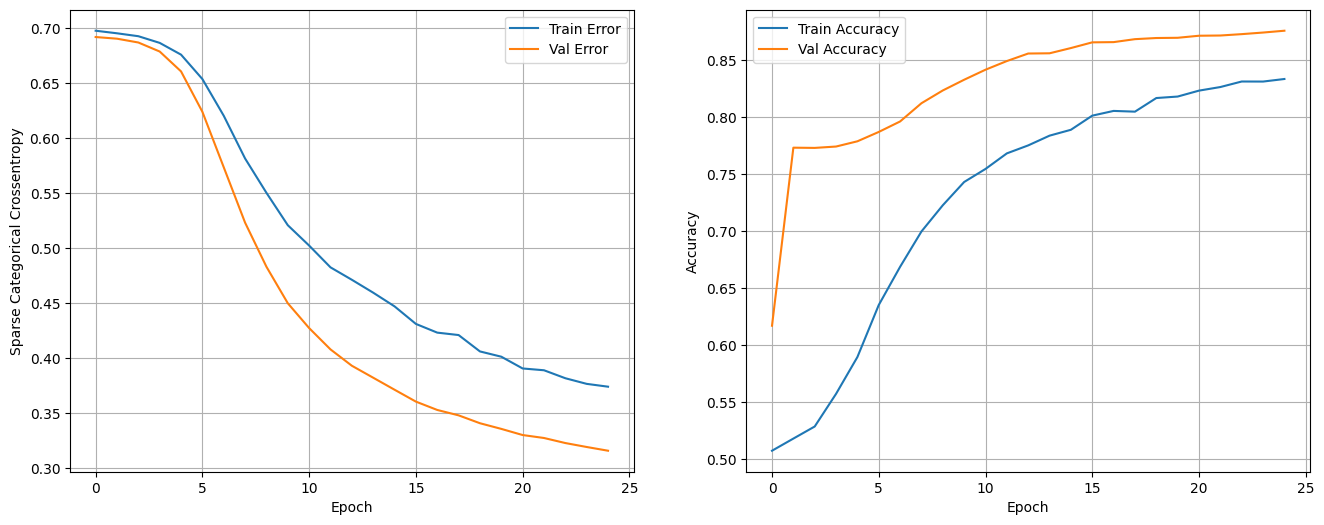

In [ ]:
show_loss_accuracy_evolution(history)

### Evaluate the model
You need to obtain a Test Accuracy > 0.85. Try to get more than 0.9!

In [ ]:
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8709 - loss: 0.3238
Test Loss: 0.3241058886051178
Test Accuracy: 0.8708000183105469


### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad']

sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

x_pred = vectorize_sequences(sequences, num_words=num_words)
np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


array([[0.0172],
       [0.9981],
       [0.3659],
       [0.8958],
       [0.0015]], dtype=float32)

# RNN model

Lets use a recurrent neural network and compare results


### Simple RNN model

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In sequence classification we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [ ]:
# dims of input: [batch, tokens, embedding_dim]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, tokens, embedding_dim): ', inputs.shape)
lstm = tf.keras.layers.LSTM(units=2)
output = lstm(inputs)
print('1. return_state=False output shape: ',output.shape)
lstm = tf.keras.layers.LSTM(units=2, return_sequences=True)
output = lstm(inputs)
print('2. return_state=True output shape: ',output.shape)

input dim (batch, tokens, embedding_dim):  (32, 10, 4)
1. return_state=False output shape:  (32, 2)
2. return_state=True output shape:  (32, 10, 2)


### Loading Data

In [ ]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
'''size = 15000
(train_data, train_labels), (test_data, test_labels) = (
    (train_data[:size], train_labels[:size]), (test_data[:size], test_labels[:size]))
'''
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

print(train_data.shape, test_data.shape)

(25000,) (25000,)


### Create the RNN model

For the input of the first rnn layer we need a tensor of `(timesteps, features)` or `(batchsize, timesteps, features)`. We have a matrix of sentences of `(train_size, max_len)`. Every sentence is a  `max_len`, we need to convert it to a sentence of one-hot vectors of dim `(max_len, num_words)`.
For get the one-hot encoding of every sequence we are going to use:

```python
layers.Embedding(input_dim=num_words, output_dim=num_words,
  input_length=max_len, embeddings_initializer='identity', trainable=False)
```

This layer converts the input tensor `(batch_size, max_len)` to one-hot encoded sequences `(batch_size, max_len, num_words)`





In [ ]:
max_len = 100
x_train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


In [ ]:
seq = np.array([[[0, 1, 2, 2, 0]]])
print(seq, seq.shape)
layers.Embedding(input_dim=3, output_dim=3,
                 input_length=5, embeddings_initializer='identity',
                 trainable=False)(seq)

[[[0 1 2 2 0]]] (1, 1, 5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<tf.Tensor: shape=(1, 1, 5, 3), dtype=float32, numpy=
array([[[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]]], dtype=float32)>

### RNN model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` or `keras.layers.Bidirectional`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))
## complete the model with recurrent layers
model.add(layers.SimpleRNN(16, return_sequences=False))

## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 2003)      │     4,012,009 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 16)             │        32,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,044,346 (15.43 MB)

 Trainable params: 32,337 (126.32 KB)

 Non-trainable params: 4,012,009 (15.30 MB)

In [ ]:
## set the loss and see the results
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)


Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.4954 - loss: 0.6961 - val_accuracy: 0.5344 - val_loss: 0.6910
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6068 - loss: 0.6738 - val_accuracy: 0.7116 - val_loss: 0.5987
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7636 - loss: 0.5237 - val_accuracy: 0.7800 - val_loss: 0.4828
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8357 - loss: 0.4023 - val_accuracy: 0.7804 - val_loss: 0.4758
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8630 - loss: 0.3506 - val_accuracy: 0.7944 - val_loss: 0.4575


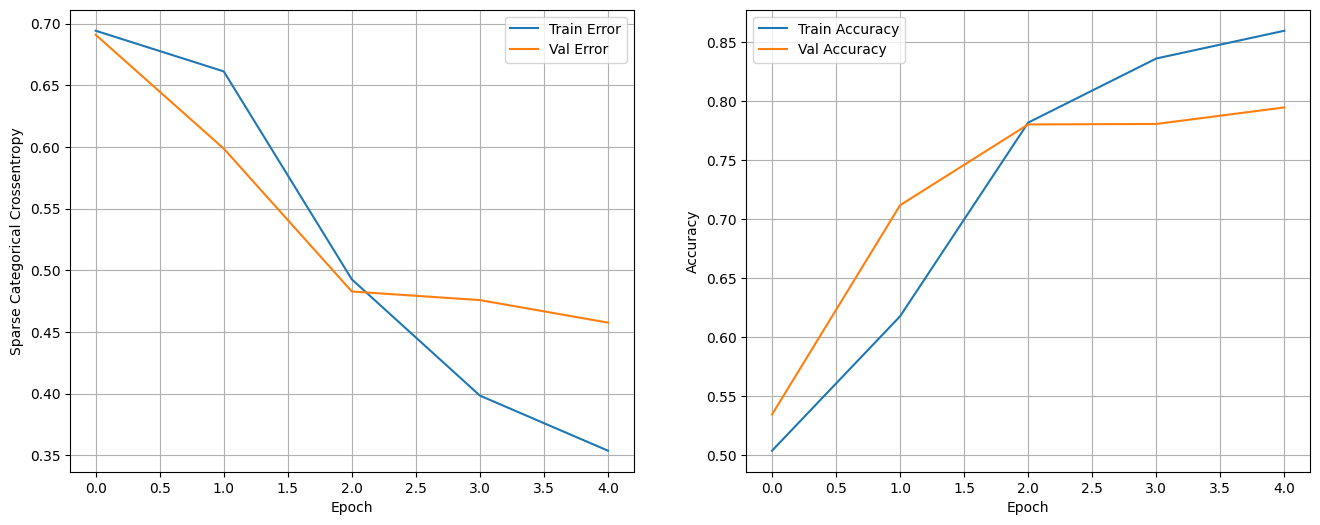

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7927 - loss: 0.4706
Test Loss: 0.47614747285842896
Test Accuracy: 0.7892400026321411


In [ ]:
show_loss_accuracy_evolution(history)
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [ ]:
def show_errors(x_test, model, labels, int2word, n_samples=10):
    preds = 1.0 * (model.predict(x_test).flatten() > 0.5)
    bad_pred_inds = np.where(preds != labels)[0]
    n_samples = min(len(bad_pred_inds), n_samples)
    samples_inds = np.random.choice(bad_pred_inds, n_samples)
    for ind in samples_inds:
        print('Predicted : {0}, real : {1}, lenght: {2}'.format(
            int(preds[ind]), labels[ind], len(test_data[ind])))
        print(get_words(test_data[ind], int2word))
        print()
    return

show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Predicted : 1, real : 0, lenght: 116
<START> and one only in my opinion br br that reason is <UNK> <UNK> she is a wonderful actress on stage as well as on the screen we have few <UNK> to see her though i think that's especially true in the <UNK> states br br here she plays a <UNK> role not only that but she is also very pretty and meant to be something of a <UNK> br br <UNK> <UNK> does not hold up the <UNK> of <UNK> <UNK> he is always <UNK> but he's not much fun he's not a <UNK> or a <UNK> this seemed to me a <UNK> <UNK> with little action or suspense but check it out for <UNK>

Predicted : 0, real : 1, lenght: 252
<START> after <UNK> up <UNK> city with a little help from <UNK> <UNK> <UNK> <UNK> goes to <UNK> <UNK> where <UNK> got a nice little <UNK> war going plus a rather interesting <UNK> of br br <UNK> scott is <UNK> <UNK> and he's after villains billy house and steve <UNK> who are driving off their <UNK> the they are driving off are in a <U

#### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


array([[0.0806],
       [0.9317],
       [0.9302],
       [0.909 ],
       [0.0793],
       [0.081 ]], dtype=float32)

In [ ]:
1.0*(model.predict(x_pred) > 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]])

### GRU model
Use `keras.layers.GRU`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.GRU(16, return_sequences=True))
model.add(layers.GRU(16, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5096 - loss: 0.6925 - val_accuracy: 0.5852 - val_loss: 0.6850
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6557 - loss: 0.6246 - val_accuracy: 0.7696 - val_loss: 0.4831
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8014 - loss: 0.4407 - val_accuracy: 0.8008 - val_loss: 0.4381
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8332 - loss: 0.3834 - val_accuracy: 0.8092 - val_loss: 0.4195
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8459 - loss: 0.3643 - val_accuracy: 0.8144 - val_loss: 0.4113


In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8086 - loss: 0.4182
Test Loss: 0.4208652377128601
Test Accuracy: 0.8073199987411499


### LSTM model
Use `keras.layers.LSTM`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.LSTM(16, return_sequences=True))
model.add(layers.LSTM(16, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5415 - loss: 0.6814 - val_accuracy: 0.7684 - val_loss: 0.5136
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7906 - loss: 0.4623 - val_accuracy: 0.8132 - val_loss: 0.4314
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8382 - loss: 0.3810 - val_accuracy: 0.8148 - val_loss: 0.4230
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8468 - loss: 0.3633 - val_accuracy: 0.8100 - val_loss: 0.4100
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8525 - loss: 0.3533 - val_accuracy: 0.8088 - val_loss: 0.4102


In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8042 - loss: 0.4227
Test Loss: 0.42592015862464905
Test Accuracy: 0.8026400208473206


### Bidirectional model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` with `keras.layers.Bidirectional`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=True))

## complete the model with recurrent layers
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=False)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## set the loss and see the results
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

epochs = 50
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.15, epochs=epochs,
                    batch_size=128, callbacks=[es_callback])

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.5546 - loss: 0.6912 - val_accuracy: 0.6285 - val_loss: 0.6799
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.6517 - loss: 0.6632 - val_accuracy: 0.7528 - val_loss: 0.5461
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7840 - loss: 0.4901 - val_accuracy: 0.7947 - val_loss: 0.4512
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.8185 - loss: 0.4120 - val_accuracy: 0.8059 - val_loss: 0.4328
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8346 - loss: 0.3856 - val_accuracy: 0.8096 - val_loss: 0.4302
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8445 - loss: 0.3712 - val_accuracy: 0.8101 - val_loss: 0.4306
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8502 - loss: 0.3624 - val_accuracy: 0.8101 - val_loss: 0.4296
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8556 - loss: 0.3559 - va

In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8060 - loss: 0.4335
Test Loss: 0.438069224357605
Test Accuracy: 0.8053200244903564


#### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


array([[0.3348],
       [0.9634],
       [0.8146],
       [0.6565],
       [0.411 ],
       [0.455 ]], dtype=float32)

In [ ]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
Predicted : 1, real : 0, lenght: 734
<START> first off the editing of this film <UNK> of one major <UNK> which i don't understand how was missed you <UNK> see the <UNK> <UNK> <UNK> in and out of the film the first time i saw it i just said well <UNK> happen and <UNK> it off after about the <UNK> time it began to get incredibly <UNK> and <UNK> funny if you haven't seen the film yet try <UNK> how many times you see the <UNK> might make for pretty interesting game br br now about the film this movie started out with the <UNK> of a pretty solid ghost story however the plot twist at the end just <UNK> it completely you begin watching the movie under the <UNK> <UNK> by the tv <UNK> that the <UNK> house <UNK> of <UNK> which can only be seen by children particularly young children which makes it even more <UNK> as they will be <UNK> to <UNK> <UNK> the family of the <UNK> <UNK> the opening scene did a good job of <UNK> the audience that this would <UNK> 

###  Use a convolutional network instead of a RNN

```python
tf.keras.layers.Conv1D(
    filters, kernel_size
)
```

```python
tf.keras.layers.MaxPool1D(
    pool_size=2
)
```

```python
tf.keras.layers.Flatten()
```

In [ ]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3


In [ ]:
max_len = 100
x_train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))


model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.5009 - loss: 0.6935 - val_accuracy: 0.5748 - val_loss: 0.6790
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6752 - loss: 0.6031 - val_accuracy: 0.8048 - val_loss: 0.4347
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8129 - loss: 0.4094 - val_accuracy: 0.8164 - val_loss: 0.4057
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8452 - loss: 0.3536 - val_accuracy: 0.8176 - val_loss: 0.4044
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8643 - loss: 0.3199 - val_accuracy: 0.8172 - val_loss: 0.4139
